# Advanced Contact-Map Graph Analysis
## Contact Energies and Folding Funnel Characterization

This notebook demonstrates:
1. Estimating individual contact formation energies from graph structure
2. Characterizing the folding funnel topology
3. Identifying bottleneck states and cooperative contacts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Import your existing modules
# Adjust these imports based on your actual codebase structure
from src.contact_energies_claude import ContactEnergyEstimator
from src.topology2_claude import FoldingFunnelAnalyzer

# Assuming you have these from your existing analysis
# from src.graph_builder import build_contact_map_graph
# from src.committor_analysis import compute_committors

## 1. Load Your Existing Graph Analysis

This assumes you've already run your contact-map graph construction.
Replace this with your actual data loading.

In [ ]:
from src import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pdb = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.xtc"

contact_maps = contacts.get_contact_maps(top=pdb, traj=xtc)
unique_maps, frame_to_uid, inds = contacts.get_unique_maps(contact_maps)

flat_bits, tri, Mbits = contacts.flatten_upper_bits(unique_maps)
ints, Mbits, tri = contacts.maps_to_upper_ints(unique_maps)
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)
G = graphs.merge_manifold_and_temporal(Gm, edge_info)

start_node = int(frame_to_uid[0])
folded_node = int(np.argmax(np.bincount(frame_to_uid)))
path_m = nx.shortest_path(Gm, source=start_node, target=folded_node)

X_emb, labels, D = clustering.embed_and_cluster_by_hamming(ints,
                                 n_components=10,
                                 embed_method='mds',   # 'mds' or 'spectral'
                                 cluster_method='agglomerative',  # 'agglomerative' or 'hdbscan'
                                 n_clusters=None,      # only for agglomerative
                                 random_state=42,
                                 warn_threshold=4000)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}


Frames: 10001 N: 10 Unique maps: 362


/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/skl

## 2. Contact Energy Estimation

Estimate individual contact formation energies from the graph structure.
Key insight: Temporal edge length in MDS space correlates with barrier height.

In [3]:
# Initialize energy estimator
energy_estimator = ContactEnergyEstimator(
    contact_maps=contact_maps,
    temporal_graph=G,
    manifold_graph=Gm,
    mds_coords=X_emb,
    temperature=300.0,  # Kelvin
    n_residues=10  # For Chignolin
)

# Estimate energies
print("Estimating contact formation energies...")
contact_energies = energy_estimator.estimate_contact_energies()

# Print summary
print(f"\nFound energies for {len(contact_energies)} contacts")
print("\nExample contact energies:")
for contact, data in list(contact_energies.items())[:5]:
    print(f"  Contact {contact}: {data['energy']:.3f} kcal/mol "
          f"(observed {data['n_observations']} times, "
          f"cooperative: {data['cooperative_fraction']:.1%})")

Estimating contact formation energies...

Found energies for 10 contacts

Example contact energies:
  Contact (0, 1): 1.156 kcal/mol (observed 553 times, cooperative: 100.0%)
  Contact (0, 4): 1.150 kcal/mol (observed 1191 times, cooperative: 100.0%)
  Contact (0, 5): 1.183 kcal/mol (observed 668 times, cooperative: 100.0%)
  Contact (0, 6): 1.130 kcal/mol (observed 441 times, cooperative: 100.0%)
  Contact (0, 7): 1.187 kcal/mol (observed 569 times, cooperative: 100.0%)


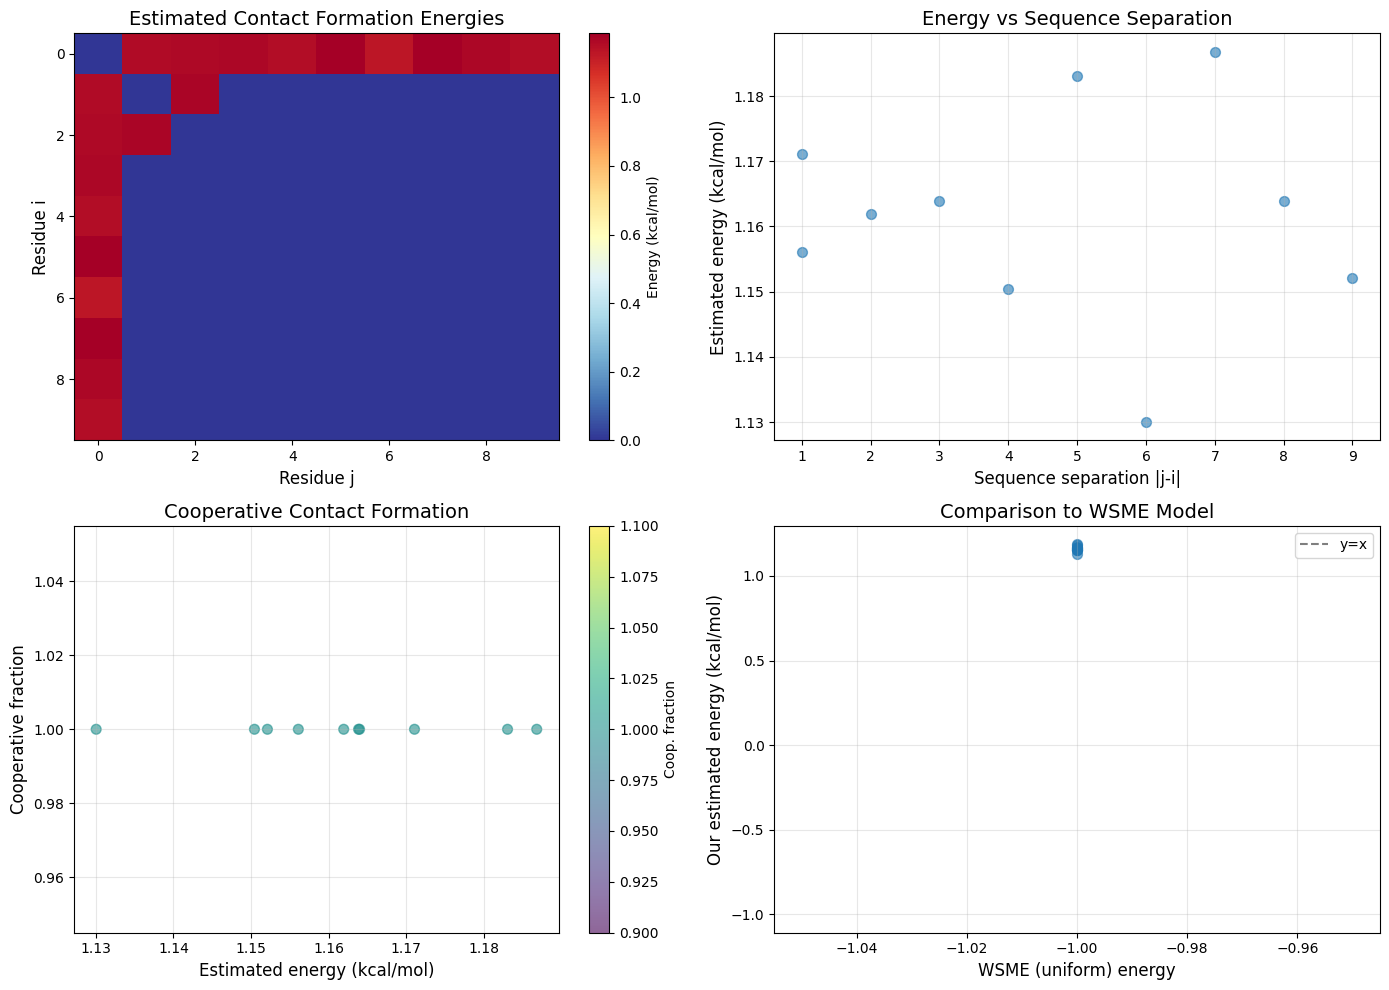


Key findings:
  Top-left: Contact energy matrix (which contacts are expensive to form?)
  Top-right: Do long-range contacts have different energies?
  Bottom-left: Cooperative contacts have lower effective barriers
  Bottom-right: Our data-driven energies vs WSME heuristics


In [5]:
# Visualize energy estimates
fig = energy_estimator.plot_energy_comparison(wsme_style='uniform')
plt.savefig('contact_energies.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey findings:")
print("  Top-left: Contact energy matrix (which contacts are expensive to form?)")
print("  Top-right: Do long-range contacts have different energies?")
print("  Bottom-left: Cooperative contacts have lower effective barriers")
print("  Bottom-right: Our data-driven energies vs WSME heuristics")

### Identify Cooperative Contact Groups

Find contacts that frequently form together (e.g., secondary structure elements).

In [6]:
# Find cooperative groups
print("Identifying cooperative contact groups...")
cooperative_groups = energy_estimator.identify_cooperative_groups(
    min_cooccurrence=3
)

print(f"\nFound {len(cooperative_groups)} cooperative groups:")
for i, group in enumerate(cooperative_groups):
    print(f"\nGroup {i+1}: {len(group)} contacts")
    print(f"  Contacts: {group[:5]}..." if len(group) > 5 else f"  Contacts: {group}")
    
    # Check if this corresponds to secondary structure
    avg_separation = np.mean([abs(j-i) for i, j in group])
    if avg_separation < 4:
        print(f"  → Likely helix/turn (avg separation: {avg_separation:.1f})")
    else:
        print(f"  → Likely long-range (avg separation: {avg_separation:.1f})")

Identifying cooperative contact groups...

Found 1 cooperative groups:

Group 1: 10 contacts
  Contacts: [(0, 1), (0, 7), (1, 2), (0, 4), (0, 3)]...
  → Likely long-range (avg separation: 4.6)


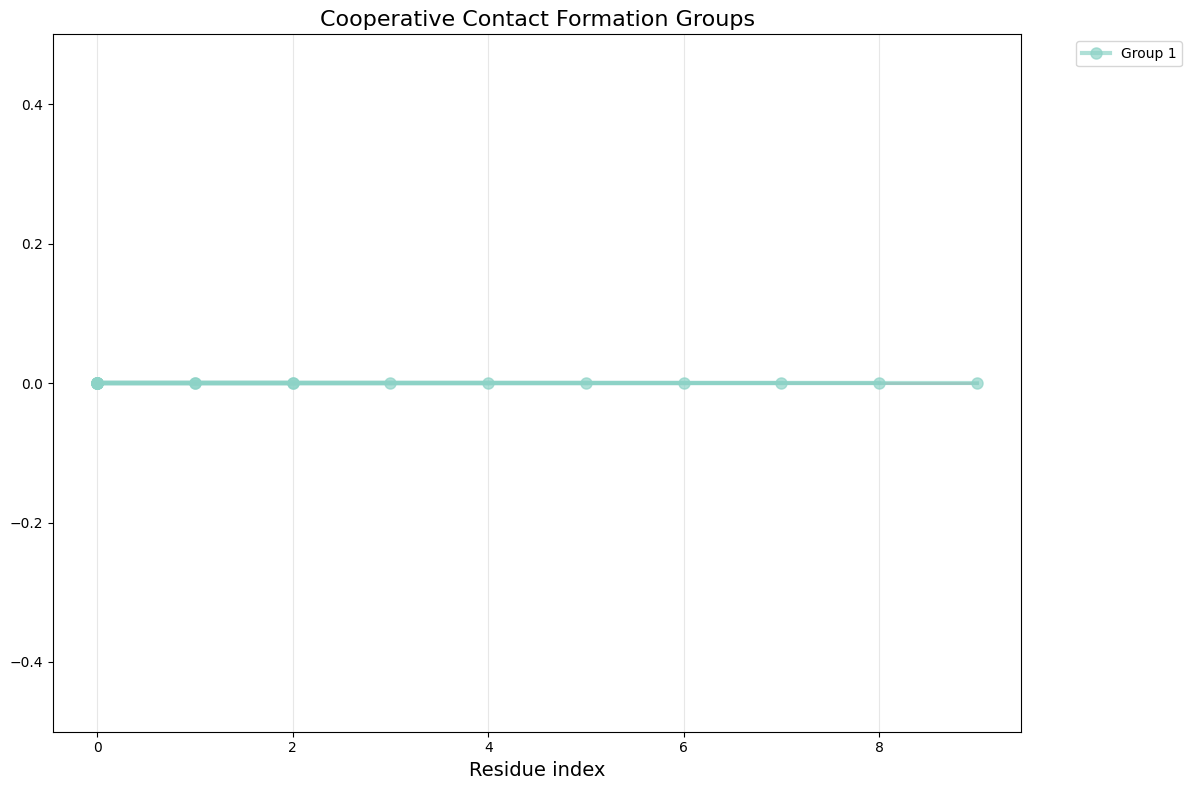

In [8]:
# Visualize cooperative groups
if len(cooperative_groups) > 0:
    fig = energy_estimator.plot_cooperative_groups()
    if fig is not None:
        plt.savefig('cooperative_groups.png', dpi=300, bbox_inches='tight')
        plt.show()

### Summary Statistics

In [9]:
# Get summary statistics
summary = energy_estimator.get_summary_statistics()

print("\n" + "="*70)
print("CONTACT ENERGY SUMMARY")
print("="*70)
print(f"Contacts observed:           {summary['n_contacts_observed']}")
print(f"Mean energy:                 {summary['mean_energy']:.3f} kcal/mol")
print(f"Energy range:                {summary['min_energy']:.3f} - {summary['max_energy']:.3f} kcal/mol")
print(f"Mean cooperative fraction:   {summary['mean_cooperative_fraction']:.1%}")
print(f"Cooperative groups:          {summary['n_cooperative_groups']}")
print(f"Highly cooperative contacts: {summary['highly_cooperative_contacts']}")
print("="*70)

print("\nInterpretation:")
if summary['mean_cooperative_fraction'] > 0.5:
    print("  → Most contacts form cooperatively (suggests nucleation mechanism)")
else:
    print("  → Contacts mostly form independently (suggests sequential mechanism)")

energy_range = summary['max_energy'] - summary['min_energy']
if energy_range > 2.0:
    print(f"  → Large energy heterogeneity ({energy_range:.1f} kcal/mol range)")
    print("    Some contacts are much harder to form than others")
else:
    print(f"  → Relatively uniform energies (range: {energy_range:.1f} kcal/mol)")


CONTACT ENERGY SUMMARY
Contacts observed:           10
Mean energy:                 1.162 kcal/mol
Energy range:                1.130 - 1.187 kcal/mol
Mean cooperative fraction:   100.0%
Cooperative groups:          1
Highly cooperative contacts: 10

Interpretation:
  → Most contacts form cooperatively (suggests nucleation mechanism)
  → Relatively uniform energies (range: 0.1 kcal/mol)


## 3. Folding Funnel Characterization

Analyze the topology of the folding landscape.

In [ ]:
# Identify folded and unfolded nodes
# Option A: If you know them explicitly
# folded_node = your_folded_node_index
# unfolded_node = your_unfolded_node_index

# Option B: Infer from committors and populations
folded_node = np.argmax(populations)  # Most populated state
unfolded_node = np.argmin(committors)  # Lowest committor

print(f"Identified states:")
print(f"  Folded node: {folded_node} (pop: {populations[folded_node]:.3f}, q: {committors[folded_node]:.3f})")
print(f"  Unfolded node: {unfolded_node} (pop: {populations[unfolded_node]:.3f}, q: {committors[unfolded_node]:.3f})")

In [ ]:
# Initialize funnel analyzer
funnel_analyzer = FoldingFunnelAnalyzer(
    graph=temporal_graph,
    committors=committors,
    populations=populations,
    free_energies=-np.log(populations),  # Approximate free energy
    folded_node=folded_node,
    unfolded_node=unfolded_node,
    mds_coords=mds_coords
)

# Compute all funnel metrics
print("\nComputing folding funnel metrics...")
metrics = funnel_analyzer.compute_funnel_metrics()

In [ ]:
# Print summary
funnel_analyzer.print_summary()

### Visualize Folding Funnel

In [ ]:
# Comprehensive funnel visualization
fig = funnel_analyzer.plot_funnel_structure(figsize=(16, 12))
plt.savefig('figures/folding_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure interpretation:")
print("  Top-left: 2D funnel projection (size=population, color=committor)")
print("  Top-right: Branching factor (high→low = funnel convergence)")
print("  Middle-right: Betweenness distribution (identifies bottlenecks)")
print("  Bottom: Free energy profile, pathway degeneracy, bottleneck identification")

### Identify Bottleneck States

In [ ]:
# Find bottleneck states (transition state ensemble)
print("\nIdentifying bottleneck states...")

# Method 1: High betweenness centrality
bottlenecks_betweenness = funnel_analyzer.identify_bottleneck_states(
    method='betweenness', top_k=5
)

# Method 2: Near q=0.5
bottlenecks_committor = funnel_analyzer.identify_bottleneck_states(
    method='committor', top_k=5
)

# Method 3: Combined score
bottlenecks_combined = funnel_analyzer.identify_bottleneck_states(
    method='combined', top_k=5
)

print("\nTop 5 bottleneck states:")
print("\nBy betweenness:")
for i, node in enumerate(bottlenecks_betweenness):
    print(f"  {i+1}. Node {node}: betweenness={metrics['betweenness'][node]:.4f}, "
          f"q={committors[node]:.3f}, pop={populations[node]:.3f}")

print("\nBy committor (q≈0.5):")
for i, node in enumerate(bottlenecks_committor):
    print(f"  {i+1}. Node {node}: q={committors[node]:.3f}, "
          f"betweenness={metrics['betweenness'][node]:.4f}")

print("\nBy combined score:")
for i, node in enumerate(bottlenecks_combined):
    print(f"  {i+1}. Node {node}: q={committors[node]:.3f}, "
          f"betweenness={metrics['betweenness'][node]:.4f}, "
          f"pop={populations[node]:.3f}")

### Analyze Contact Formation Order Along Pathways

In [ ]:
# Get dominant pathways from funnel analysis
if 'path_degeneracy' in metrics and 'paths' in metrics['path_degeneracy']:
    paths = metrics['path_degeneracy']['paths']
    
    print(f"\nAnalyzing contact formation along {len(paths)} pathways...")
    
    # For the shortest path, show which contacts form when
    if len(paths) > 0:
        shortest_path = paths[0]
        print(f"\nShortest path ({len(shortest_path)} states):")
        print(f"  {shortest_path}")
        
        # Track contact formation along path
        print("\nContact formation timeline:")
        prev_contacts = set()
        
        for step, node in enumerate(shortest_path):
            if node < len(contact_maps):
                current_contacts = set(
                    tuple(energy_estimator.contact_pairs[i]) 
                    for i in np.where(contact_maps[node])[0]
                )
                
                newly_formed = current_contacts - prev_contacts
                newly_broken = prev_contacts - current_contacts
                
                if newly_formed or newly_broken:
                    print(f"\n  Step {step} (node {node}, q={committors[node]:.2f}):")
                    if newly_formed:
                        print(f"    Formed: {list(newly_formed)[:3]}..." 
                              if len(newly_formed) > 3 else f"    Formed: {list(newly_formed)}")
                    if newly_broken:
                        print(f"    Broken: {list(newly_broken)[:3]}..." 
                              if len(newly_broken) > 3 else f"    Broken: {list(newly_broken)}")
                
                prev_contacts = current_contacts
else:
    print("\nNo pathway data available (graph may be disconnected)")

## 4. Integration: Energies + Funnel

Combine insights from both analyses.

In [ ]:
# Question: Are bottleneck states characterized by formation of high-energy contacts?

print("\nBottleneck states and contact energies:")
print("="*70)

for i, node in enumerate(bottlenecks_combined[:3]):
    print(f"\nBottleneck {i+1} (node {node}):")
    print(f"  Committor: {committors[node]:.3f}")
    print(f"  Betweenness: {metrics['betweenness'][node]:.4f}")
    
    # Find which contacts are formed at this state
    if node < len(contact_maps):
        formed_contacts_idx = np.where(contact_maps[node])[0]
        formed_contacts = [energy_estimator.contact_pairs[i] for i in formed_contacts_idx]
        
        # Get energies of formed contacts
        energies_here = [
            contact_energies[c]['energy'] 
            for c in formed_contacts 
            if c in contact_energies
        ]
        
        if len(energies_here) > 0:
            print(f"  Contacts formed: {len(formed_contacts)}")
            print(f"  Mean contact energy: {np.mean(energies_here):.3f} kcal/mol")
            print(f"  Max contact energy: {np.max(energies_here):.3f} kcal/mol")
            
            # Identify highest-energy contact
            max_energy_idx = np.argmax(energies_here)
            max_energy_contact = formed_contacts[max_energy_idx]
            print(f"  Hardest contact: {max_energy_contact} "
                  f"({energies_here[max_energy_idx]:.3f} kcal/mol)")

print("\n" + "="*70)

## 5. Export Results for Blog

Save key findings and figures.

In [ ]:
# Save numerical results
results = {
    'contact_energies': contact_energies,
    'cooperative_groups': cooperative_groups,
    'funnel_metrics': metrics,
    'bottleneck_states': bottlenecks_combined.tolist(),
    'energy_summary': summary
}

import json
with open('results/advanced_analysis_results.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    json_results = {}
    for key, value in results.items():
        if isinstance(value, np.ndarray):
            json_results[key] = value.tolist()
        elif isinstance(value, dict):
            json_results[key] = {str(k): v for k, v in value.items()}
        else:
            json_results[key] = value
    json.dump(json_results, f, indent=2)

print("Results saved to results/advanced_analysis_results.json")
print("Figures saved to figures/")

## Summary

This analysis provides:

1. **Contact Formation Energies**: Data-driven estimation of individual ε_ij values
2. **Cooperative Groups**: Which contacts form together (secondary structure)
3. **Funnel Structure**: Topological characterization of folding landscape
4. **Bottleneck Identification**: True transition state ensemble
5. **Mechanistic Insights**: Contact formation order along pathways

These complement your basic contact-map graph analysis with:
- **Physics grounding** via energy estimation
- **Topological rigor** via betweenness/branching analysis
- **Experimental connections** via cooperative groups